Количество шагов за день зависит от ряда показателей.
В указанной выборке значимым показателем может быть день недели (рабочий/выходной день), так как, например, большое число шагов для воскресенья может быть нормой, а для понедельника - чем-то необычным.
Для определения признака обычный/необычный день можно воспользоваться формулой для поиска выбросов, основанной на медиане и квартилях распределения, так как медиана устойчива к выбросам в данных: 

$$( Q_{25} - 1.5 * (Q_{75} - Q_{25}),  Q_{75} + 1.5 * (Q_{75} - Q_{25})) $$

Если значение не попадает в указанный интервал, то считаем его выбросом (необычным днем). 



In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from scipy import stats
sns.set()

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
os.chdir('C://Welltory')
import warnings
warnings.simplefilter('ignore')

In [2]:
# чтение данных из файла
data = pd.read_csv('data.csv')
data.shape

(39671, 7)

In [4]:
data.head(10)

,Time End,Time End Local Tz,Time Offset,Time Start,Time Start Local Tz,User ID,Value
0,2019-05-05T09:40:00+03:00,2019-05-05T12:40:00+03:00,10800,2019-05-05T09:39:59+03:00,2019-05-05T12:39:59+03:00,2166,1.0
1,2019-05-05T11:13:29+03:00,2019-05-05T14:13:29+03:00,10800,2019-05-05T11:12:51+03:00,2019-05-05T14:12:51+03:00,2166,34.0
2,2019-05-05T12:07:42+03:00,2019-05-05T15:07:42+03:00,10800,2019-05-05T12:07:39+03:00,2019-05-05T15:07:39+03:00,2166,1.0
3,2019-05-05T13:04:05+03:00,2019-05-05T16:04:05+03:00,10800,2019-05-05T13:04:02+03:00,2019-05-05T16:04:02+03:00,2166,3.0
4,2019-05-05T13:18:18+03:00,2019-05-05T16:18:18+03:00,10800,2019-05-05T13:18:13+03:00,2019-05-05T16:18:13+03:00,2166,6.0
5,2019-05-05T14:59:59+03:00,2019-05-05T17:59:59+03:00,10800,2019-05-05T14:58:09+03:00,2019-05-05T17:58:09+03:00,2166,77.0
6,2019-05-05T17:12:35+03:00,2019-05-05T20:12:35+03:00,10800,2019-05-05T17:11:36+03:00,2019-05-05T20:11:36+03:00,2166,61.0
7,2019-05-05T17:21:00+03:00,2019-05-05T20:21:00+03:00,10800,2019-05-05T17:20:06+03:00,2019-05-05T20:20:06+03:00,2166,69.0
8,2019-05-05T17:35:48+03:00,2019-05-05T20:35:48+03:00,10800,2019-05-05T17:35:36+03:00,2019-05-05T20:35:36+03:00,2166,17.0
9,2019-05-05T18:03:48+03:00,2019-05-05T21:03:48+03:00,10800,2019-05-05T18:03:41+03:00,2019-05-05T21:03:41+03:00,2166,9.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39671 entries, 0 to 39670
Data columns (total 7 columns):
Time End               39671 non-null object
Time End Local Tz      39671 non-null object
Time Offset            39671 non-null int64
Time Start             39671 non-null object
Time Start Local Tz    39671 non-null object
User ID                39671 non-null int64
Value                  39671 non-null float64
dtypes: float64(1), int64(2), object(4)
memory usage: 2.1+ MB


In [4]:
# наличие пропусков в данных
data.isna().sum()

Time End               0
Time End Local Tz      0
Time Offset            0
Time Start             0
Time Start Local Tz    0
User ID                0
Value                  0
dtype: int64

In [5]:
print(data[['Time Start Local Tz', 'Value']].nlargest(12, 'Value'))

             Time Start Local Tz    Value
11538  2019-08-04T22:40:05+03:00  13508.0
11435  2019-08-04T13:44:59+03:00  10994.0
11535  2019-08-04T21:32:37+03:00   8532.0
11425  2019-08-04T03:23:56+03:00   4165.0
11433  2019-08-04T13:10:26+03:00   2769.0
11426  2019-08-04T07:52:02+03:00   2754.0
11432  2019-08-04T11:40:20+03:00   2651.0
11437  2019-08-04T17:15:43+03:00   2045.0
11430  2019-08-04T10:57:44+03:00   2027.0
34707  2019-08-04T18:50:07+03:00   1685.0
11428  2019-08-04T10:36:06+03:00   1360.0
11440  2019-08-04T19:29:26+03:00   1112.0


###### Судя по данным, на 04.08.2019 приходится наибольшее число шагов

In [6]:
# группируем данные и добавляем временные признаки
data['Time Start Local Tz'] = pd.to_datetime(data['Time Start Local Tz']) + pd.Timedelta('03:00:00')
data['Time Start Local Tz'] = data['Time Start Local Tz'].dt.normalize()
data = data[['Time Start Local Tz', 'Value']]
data = data.groupby(['Time Start Local Tz'])['Value']\
                     .agg(np.sum)\
                     .reset_index()
data['weekday'] = data['Time Start Local Tz'].dt.weekday


## Графики

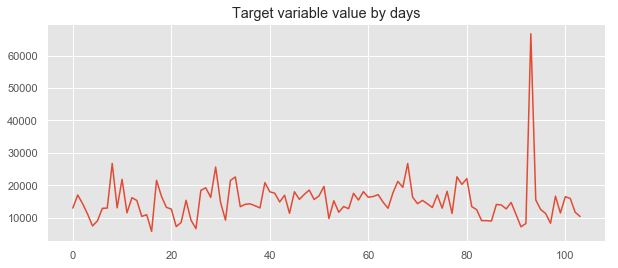

In [7]:
plt.title('Target variable value by days')
data.Value.plot(figsize=(10, 4))

###### На графике видим пик, который приходится на август месяц (04.08). В целом виден тренд к понижению количества шагов за день (в августе)

6.633960687642965e-14


Text(0.5, 1.0, 'Distribution of the target variable')

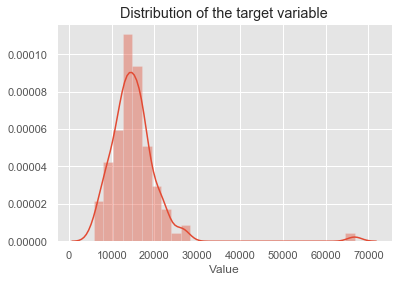

In [8]:
#Критерий Шапиро-Уилка
stat, p = stats.shapiro(data.Value)
print(p)

sns.distplot(data.Value)
plt.title('Distribution of the target variable')

###### Отклоняем H0 о том, что данные имеют нормальное распределение (p < 0.05)

Text(0.5, 1.0, 'Target variable by weekdays (boxplot)')

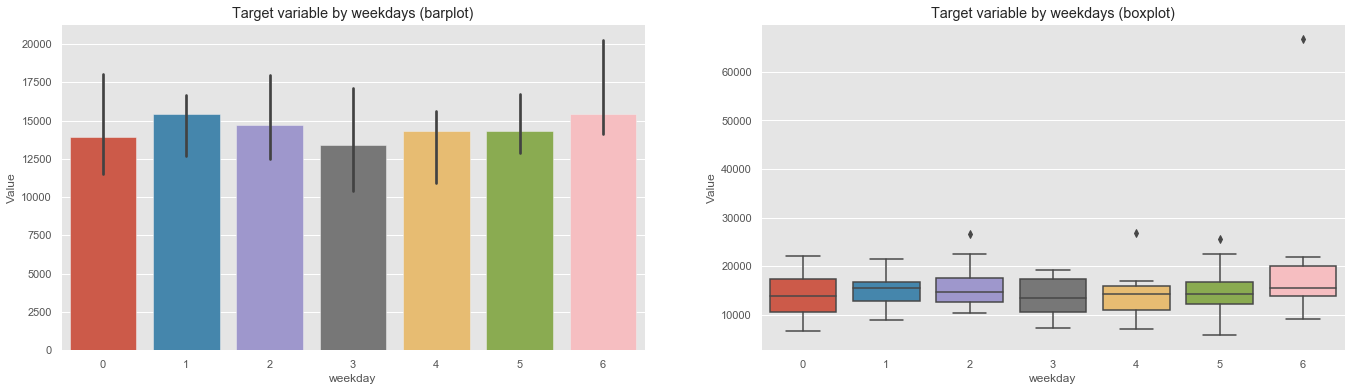

In [9]:
_, axes = plt.subplots(1, 2, figsize=(23, 6))
sns.barplot(x='weekday', y='Value', data=data, ax=axes[0], estimator=np.median)
sns.boxplot(x='weekday', y='Value', data=data, ax=axes[1])
axes[0].set_title('Target variable by weekdays (barplot)')
axes[1].set_title('Target variable by weekdays (boxplot)')


###### Из графиков видно, что есть различия в медианных значениях по дням недели. Также различается и межквартильный размах.



## Функция для определения обычный/необычный день

In [8]:
def is_unusual_day(data, UserID):        
    ''' Return dataframe with 2 columns: date and feature - usual or unusual day'''
    
    data = data.loc[data['User ID'] == UserID]
    assert len(data) != 0, 'No data for user'
    
    data['Time Start Local Tz'] = pd.to_datetime(data['Time Start Local Tz']) + pd.Timedelta('03:00:00')
    data['Time Start Local Tz'] = data['Time Start Local Tz'].dt.normalize()
    data = data[['Time Start Local Tz', 'Value']]
    data = data.groupby(['Time Start Local Tz'])['Value']\
                        .agg(np.sum)\
                        .reset_index()    
    data['weekday'] = data['Time Start Local Tz'].dt.weekday   
    d = {}
    for el in data.weekday.unique():
        t = data.loc[data.weekday == el]
        q1, q3 = np.quantile(t.Value, [0.25, 0.75])
        d[el] = (q1 - 1.5 * (q3 - q1), q3 + 1.5 * (q3 - q1))

    data['is_unusual_day'] = data.apply(lambda row: 
        ((row.Value < d[row.weekday][0]) | (row.Value > d[row.weekday][1]) ).astype(np.int8), 
        axis=1)
    
    return data[['Time Start Local Tz', 'is_unusual_day']]    
    

data = pd.read_csv('data.csv')
result = is_unusual_day(data, 2166)

result.is_unusual_day.value_counts() 

0    100
1      4
Name: is_unusual_day, dtype: int64

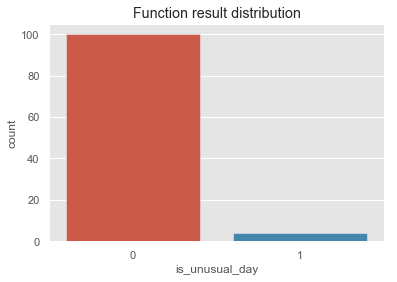

In [9]:
# визуализация результата работы функции
plt.title('Function result distribution')
sns.countplot(result.is_unusual_day)

Как видно из графика, если применить формулу для поиска выбросов (приведена в начале ноутбука), то количество обычных дней
значительно превышает количество необычных, то есть модель поведения пользователя достаточно стандартна, если смотреть по дням недели.